# All Tropical Cyclones



```{glue:figure} tracks_fig
:scale: 40%
:align: left
```


```{glue:figure} time_cat_fig
:scale: 70%
:align: right
```

**Figure. Tropical cyclones (TCs) in the vicinity of Palau since 1950.**  Map showing all TC tracks in the vicinity of Palau (top) and annual storm count (bottom).  Categorizes are colored following the Saffir Simpson scale for wind intensity (see text for details). Grey represents TCs where no wind information is available.  The dashed black line represents a trend that is not statistically significant.   

In this notebook we will analyze the historical tropical cyclones  in the Vicinity of Palau, as well as: <br>
<br>
- The number of tropical cyclones per year <br>
- The trend in the number of tropical cyclones over time <br>
- The distribution of categories over time <br>
- The influence of El Niño Southern Oscillation

## Setup

First, we need to import all the necessary libraries. Some of them are specifically developed to handle the download and plotting of the data and are hosted at the [indicators set-up repository](https://github.com/lauracagigal/indicators_setup) in GitHub

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
import os.path as op
import xarray as xr
import pandas as pd
from myst_nb import glue 
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../../../functions")
from tcs import Extract_Circle, get_ibtracs_category
from data_downloaders import download_ibtracs

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_tcs import Plot_TCs_HistoricalTracks_Category
from ind_setup.plotting import plot_bar_probs, plot_tc_categories_trend

from ind_setup.plotting import plot_bar_probs_ONI, add_oni_cat
from data_downloaders import  download_oni_index


In [2]:
lon_lat = [134.5, 5.5] #Palau location lon, lat
basin = 'WP'
r1 = 5 # Radius of the circular area in degrees

## IBTrACS
IBTrACS (International Best Track Archive for Climate Stewardship) is the most comprehensive global database of tropical cyclones. It compiles data from all major meteorological agencies worldwide, providing track, intensity, and metadata for storms from 1842 to present. It supports research on cyclone trends, risks, and climate variability.

In [3]:
update_data = False
path_data = "../../../data"
path_figs = "../../../matrix_cc/figures"

In [4]:
if update_data:
    url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/netcdf/IBTrACS.ALL.v04r01.nc'
    tcs = download_ibtracs(url, basin = basin)
    tcs.to_netcdf(f"{path_data}/tcs_{basin}.nc")
else:
    tcs = xr.load_dataset(f"{path_data}/tcs_{basin}.nc")

## Analysis

In [5]:
tcs = tcs.isel(storm = np.where(tcs.isel(date_time = 0).time.dt.year >= 1950)[0])    

In [6]:
# tcs = xr.open_dataset('/Users/laurac/Downloads/IBTrACS.ALL.v04r01.nc')

In [7]:
d_vns = {
    'longitude': 'lon',
    'latitude': 'lat',
    'time': 'time',
    'pressure': 'wmo_pres',
    'wind': 'wmo_wind',
}
tcs_sel, tcs_sel_params = Extract_Circle(tcs, lon_lat[0], lon_lat[1], r1, d_vns, fillwinds=True)

In [8]:
tcs_WP = get_ibtracs_category(tcs, d_vns)

/Users/laurac/Library/Mobile Documents/com~apple~CloudDocs/Projects/CC_indicators/CC_indicators/notebooks_historical/atmosphere/4_tropical_cyclones/../../../functions/tcs.py:31: RankWarning: Polyfit may be poorly conditioned
  linreg = np.polyfit(xfit[~mask], yfit[~mask], 2)


The static plot below shows all the TCs in the vicinity of Palau colored by its category.

In [9]:
tcs_sel_params['category'] = (('storm'), np.where(np.isnan(tcs_sel_params.category), -1, tcs_sel_params.category))
tcs_WP['category'] = (('storm'), np.where(np.isnan(tcs_WP.category), -1, tcs_WP.category))

## Plotting

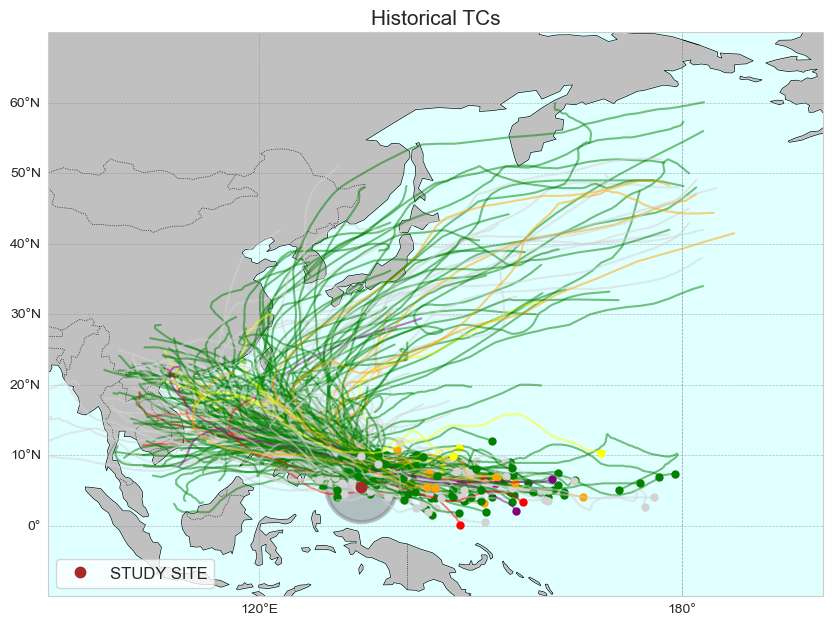

In [10]:
lon1, lon2 = 90, 200
lat1, lat2 = -10, 70

# r1
fig, ax = Plot_TCs_HistoricalTracks_Category(
    tcs_sel, tcs_sel_params.category,
    lon1, lon2, lat1, lat2,
    lon_lat[0], lon_lat[1], r1,
)

plt.savefig(op.join(path_figs, 'F8_TCs_Historical.png'), dpi=300, bbox_inches='tight')
glue("tracks_fig", fig, display=False)


Plot of the TC count per month showing the seasonality of TC genesis in the area

Text(0.5, 0, 'Month')

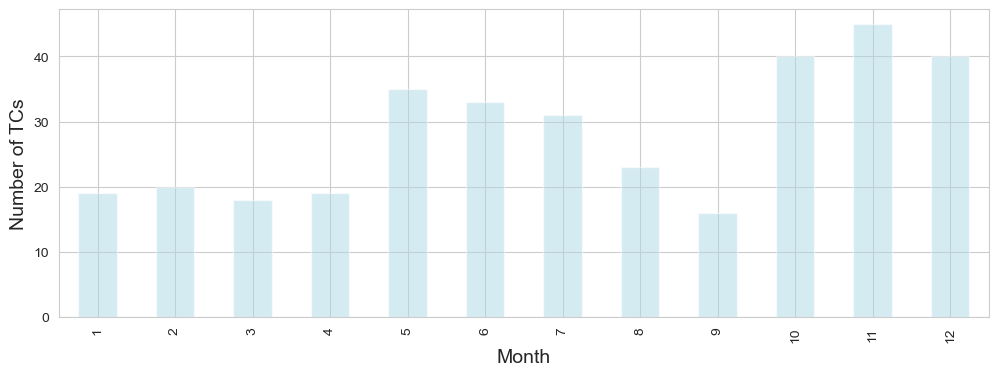

In [11]:
import matplotlib.pyplot as plt
tcs_sel_params['month'] =  tcs_sel_params.dmin_date.dt.month
tcs_sel_params.to_dataframe().groupby('month').count().index_in.plot.bar(figsize = (12, 4), color = 'lightblue', alpha = .5)
plt.ylabel('Number of TCs', fontsize = 14)
plt.xlabel('Month', fontsize = 14)

## Count TCs by category

The bar plot below displays the TC count per category in the whole record and also to the record limited to 1979 and after.

In [12]:
u, c = np.unique(tcs_sel_params.category, return_counts=True)

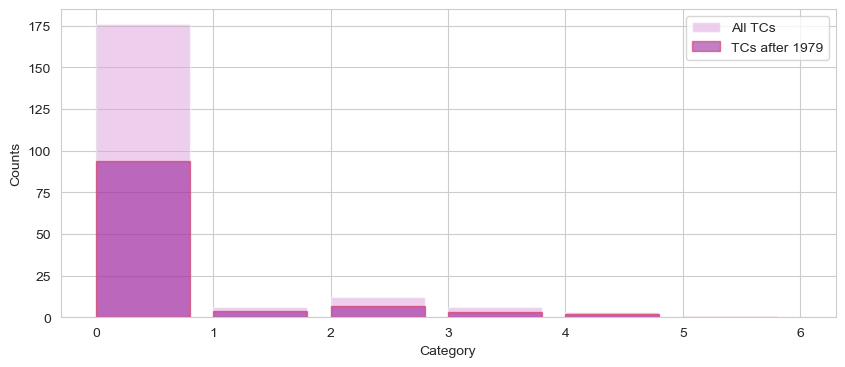

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(10, 4))
ax.grid(zorder = -1)
tcs_sel_params.category.plot.hist(bins=range(7), ax=ax, color='plum', alpha=0.5, edgecolor= None, width = .8, linewidth=1, label = 'All TCs')
tcs_sel_params.where(tcs_sel_params.dmin_date.dt.year >=1979, 
                     drop = True).category.plot.hist(bins=range(7), ax=ax, 
                                                     color='darkmagenta', alpha=0.5, edgecolor='crimson', width = .8, linewidth=1, label = 'TCs after 1979')
ax.set_xlabel('Category')
ax.set_ylabel('Counts')

ax.legend()

The plot below shows the trend of the number of TCs per year over time.

(<Figure size 1500x400 with 1 Axes>, <Axes: ylabel='Number TCs'>)

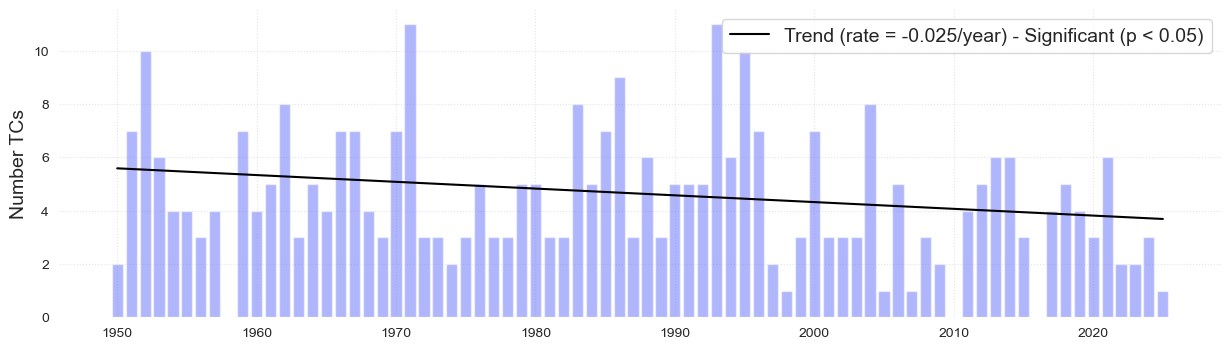

In [14]:
time = tcs_sel_params.dmin_date.dt.year.values
u, cu = np.unique(time, return_counts=True)
plot_bar_probs(x = u, y = cu, figsize= (15, 4), trendline = True,
               y_label =  'Number TCs')

The following bar plot displays the TC count per year and per category, as well as the trend. <br>
 The grey color represent those TCs in the record where no pressure or wind information is available to determine the corresponding category.

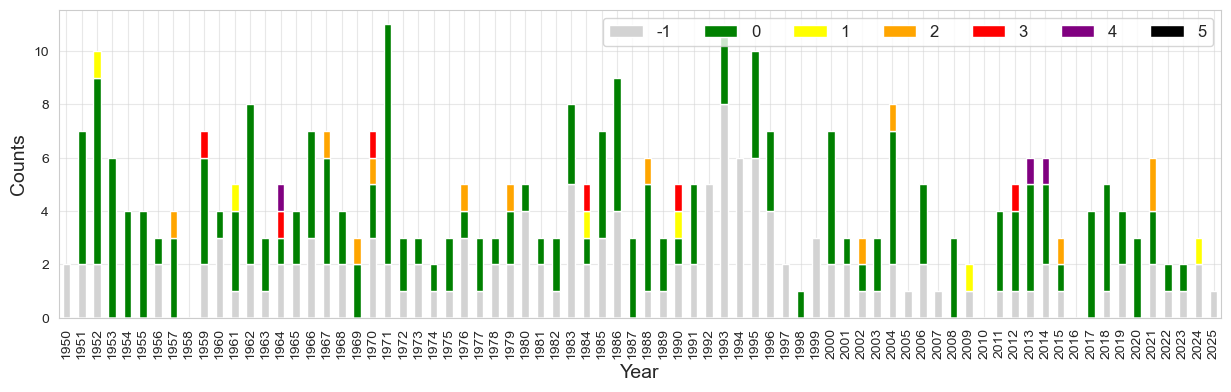

In [15]:
fig = plot_tc_categories_trend(tcs_sel_params, trendline_plot = False)
plt.savefig(op.join(path_figs, 'F8_TCs_Historical_bars_category.png'), dpi=300, bbox_inches='tight')
glue("time_cat_fig", fig, display=False)


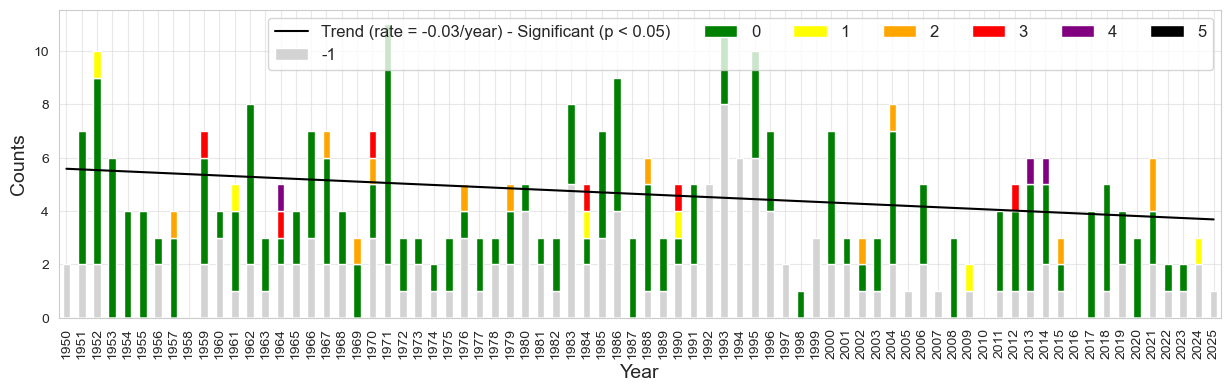

In [16]:
fig = plot_tc_categories_trend(tcs_sel_params, trendline_plot = True)
plt.savefig(op.join(path_figs, 'F8_TCs_Historical_bars_category.png'), dpi=300, bbox_inches='tight')
glue("time_cat_fig", fig, display=False)


To showcase the spatial distribution of the TC tracks for the different categories, a map is shown below representing all the TCs in the record for each category.

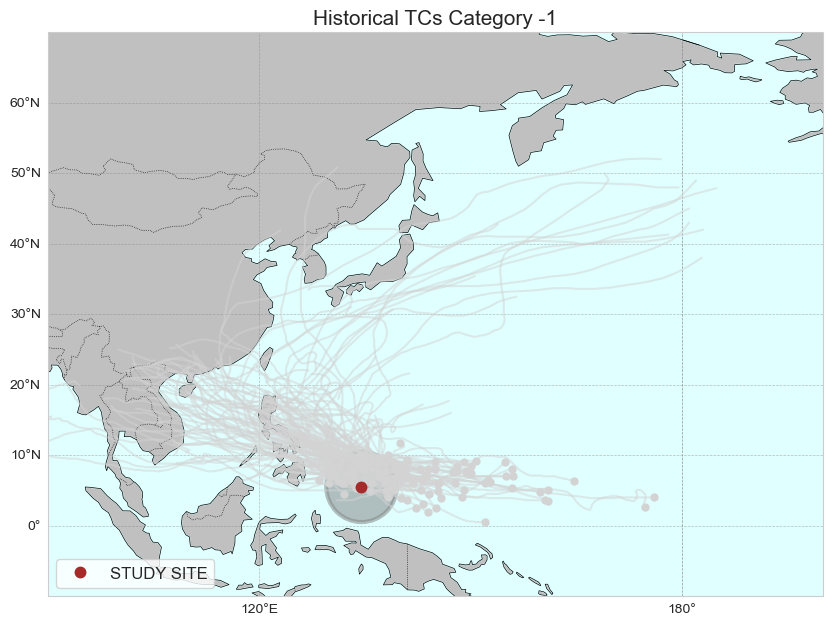

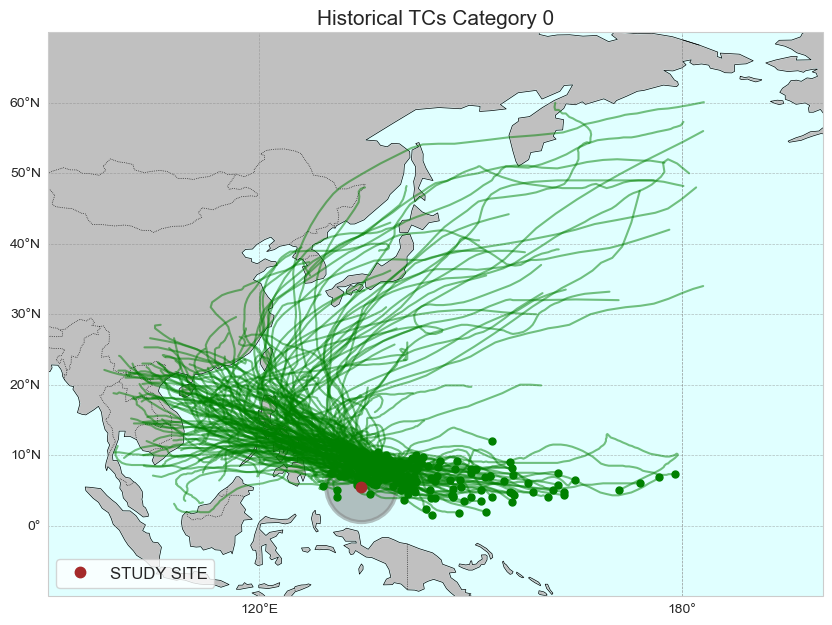

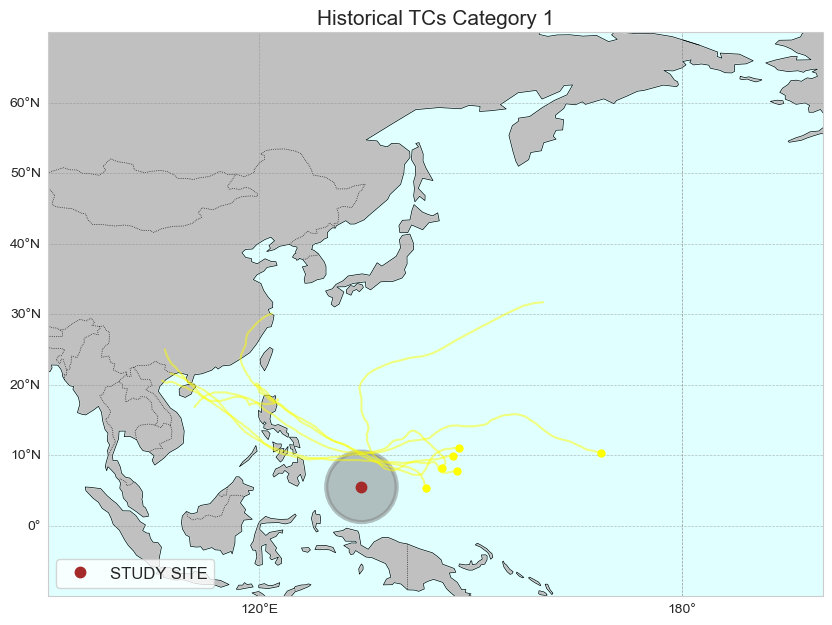

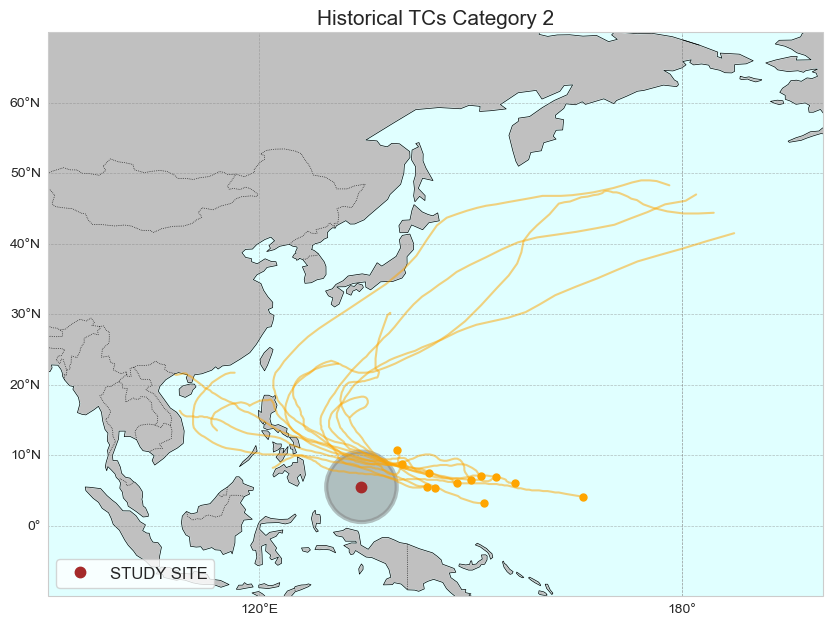

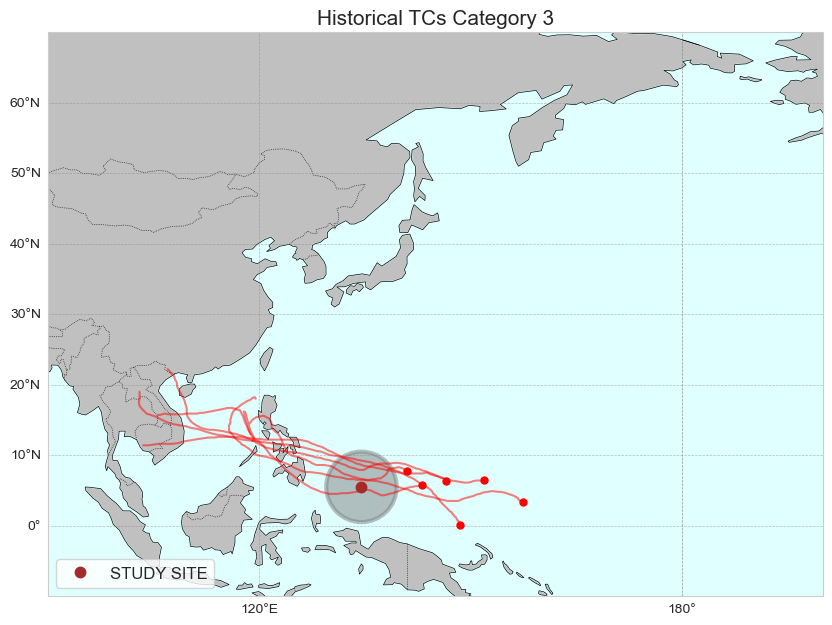

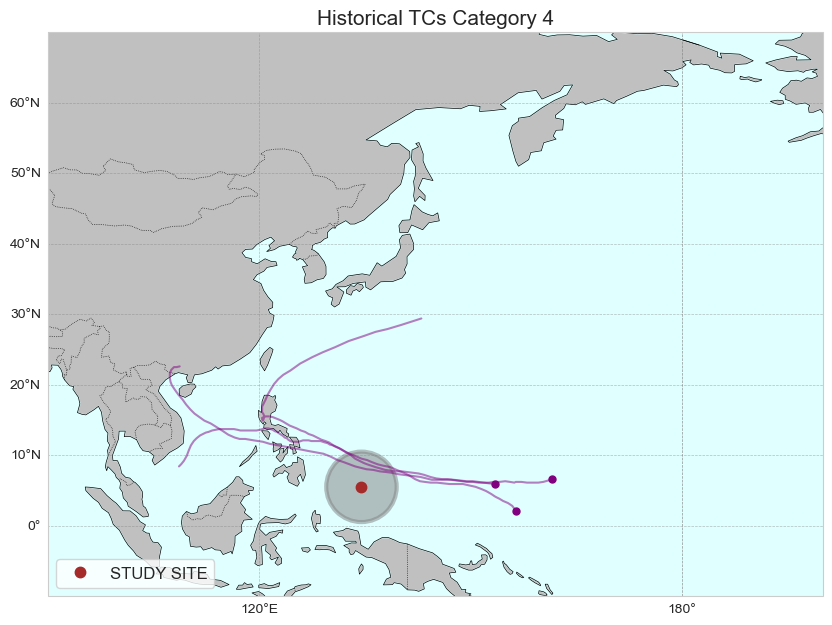

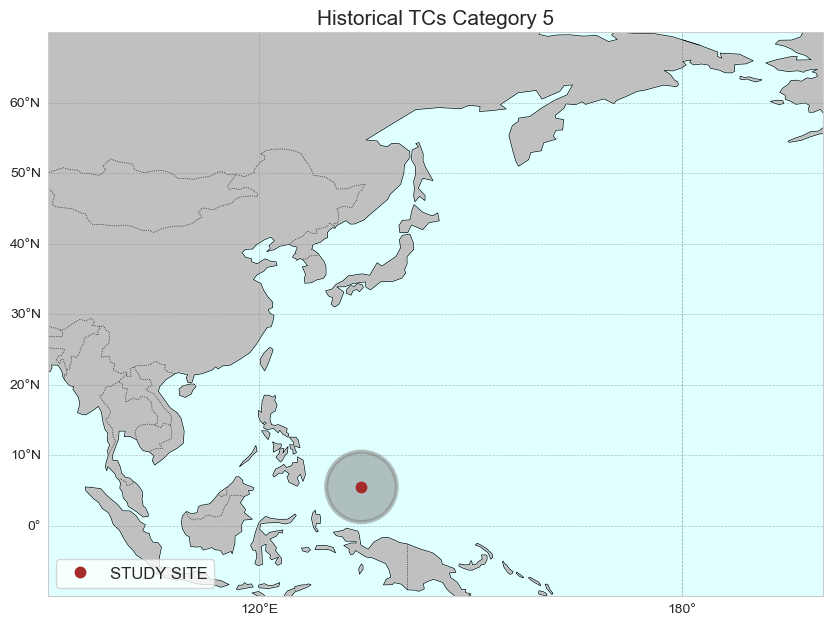

In [17]:

for category in np.arange(-1, 6, 1):

    tcs_cat = tcs_sel.where(tcs_sel_params.category == category, drop = True)
    tcs_cat_params = tcs_sel_params.where(tcs_sel_params.category == category, drop = True)

    # r1
    fig, ax = Plot_TCs_HistoricalTracks_Category(
        tcs_cat, tcs_cat_params.category,
        lon1, lon2, lat1, lat2,
        lon_lat[0], lon_lat[1], r1,
    )
    ax.set_title(f'Historical TCs Category {category}', fontsize=15)

### Generate table
Table sumarizing different metrics of the data analyzed in the plots above <br>
Number of TCs for each category

In [18]:
df_tcs = tcs_sel_params.to_dataframe()
df_tcs['year'] = df_tcs.dmin_date.dt.year
df_t = df_tcs.groupby('category').count()[['pressure_min']]
# fig = plot_df_table(df_t, figsize = (300, 220))

mean_tcs_per_year = df_tcs.groupby(df_tcs['dmin_date'].dt.year)['pressure_min'].count()

df_sev = df_tcs.loc[df_tcs['category'] >=3]
mean_tcs_per_year_sev = df_sev.groupby(df_sev['dmin_date'].dt.year)['pressure_min'].count()

print('Mean TCs per year: ', np.nanmean(mean_tcs_per_year))
print('Mean number of severe TCs per year: ', np.round(np.nanmean(mean_tcs_per_year_sev), 2))


Mean TCs per year:  2.780821917808219
Mean number of severe TCs per year:  1.12


## ONI index

The Oceanic Niño Index (ONI) is the standard measure used to monitor El Niño and La Niña events. It is based on sea surface temperature anomalies in the central equatorial Pacific (Niño 3.4 region) averaged over 3-month periods. 

https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

In [19]:
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'

In [20]:
if update_data:
    df1 = download_oni_index(p_data)
    df1.to_pickle(op.join(path_data, 'oni_index.pkl'))
else:
    df1 = pd.read_pickle(op.join(path_data, 'oni_index.pkl'))

oni = df1

In [21]:
lims = [-.5, .5]
df1 = add_oni_cat(df1, lims = lims)

In [22]:
import pandas as pd
tcs_g = pd.DataFrame(tcs_sel.isel(date_time = 0).time.values)
tcs_g.index = tcs_g[0]
tcs_g.index = pd.DatetimeIndex(tcs_g.index).to_period('M').to_timestamp() + pd.offsets.MonthBegin(0)
tcs_g['oni_cat'] = oni.oni_cat

In [23]:
print('Number of La Niña years:', len(oni.loc[oni.oni_cat == -1].index.year.unique()))
print('Number of El Niño years:', len(oni.loc[oni.oni_cat == 1].index.year.unique()))
print('Number of Neutral years:', len(oni.loc[oni.oni_cat == 0].index.year.unique()))

Number of La Niña years: 25
Number of El Niño years: 22
Number of Neutral years: 28


In [24]:
tcs_sel_params['oni_cat'] = (('storm'), tcs_g['oni_cat'].values)
tcs_sel['oni_cat'] = (('storm'), tcs_g['oni_cat'].values)

In [25]:
# oni['ONI_cat'] = np.where(oni.ONI < lims[0], -1, np.where(oni.ONI > lims[1], 1, 0))
tcs_sel_params['oni_cat'] = (('storm'), tcs_sel.oni_cat.values)

In [26]:
oni_perc_cat = oni.groupby('oni_cat').size() / oni.shape[0] * 100
oni_perc_cat

oni_cat
-1    33.333333
 0    37.333333
 1    29.333333
dtype: float64

In [27]:
tcs_perc_cat = tcs_sel_params.to_dataframe().groupby('oni_cat').size() * 100 / tcs_sel_params.to_dataframe().shape[0]
tcs_perc_cat

oni_cat
-1.0    30.383481
 0.0    43.952802
 1.0    25.073746
dtype: float64

In [28]:
#Relavice probability
tcs_perc_cat / oni_perc_cat

oni_cat
-1.0    0.911504
 0.0    1.177307
 1.0    0.854787
dtype: float64

In [29]:
time = tcs_sel_params.dmin_date.dt.year.values
u, cu = np.unique(time, return_counts=True)
tc_c = pd.DataFrame(cu, index = u)
time_sev = tcs_sel_params.where(tcs_sel_params.category >= 3, drop = True).dmin_date.dt.year.values
u_sev, cu_sev = np.unique(time_sev, return_counts=True)
tc_c_sev = pd.DataFrame(cu_sev, index = u_sev)

In [30]:
oni_y = oni.groupby(oni.index.year).min()
oni_y['tc_counts'] = tc_c
oni_y['tc_counts_sev'] = tc_c_sev

In [31]:
oni_y['oni_cat'] = oni_y.oni_cat.values

The following bar plot represents the TC counts over time. The color of the bar represents wether it is a El Niño or La Niña year.

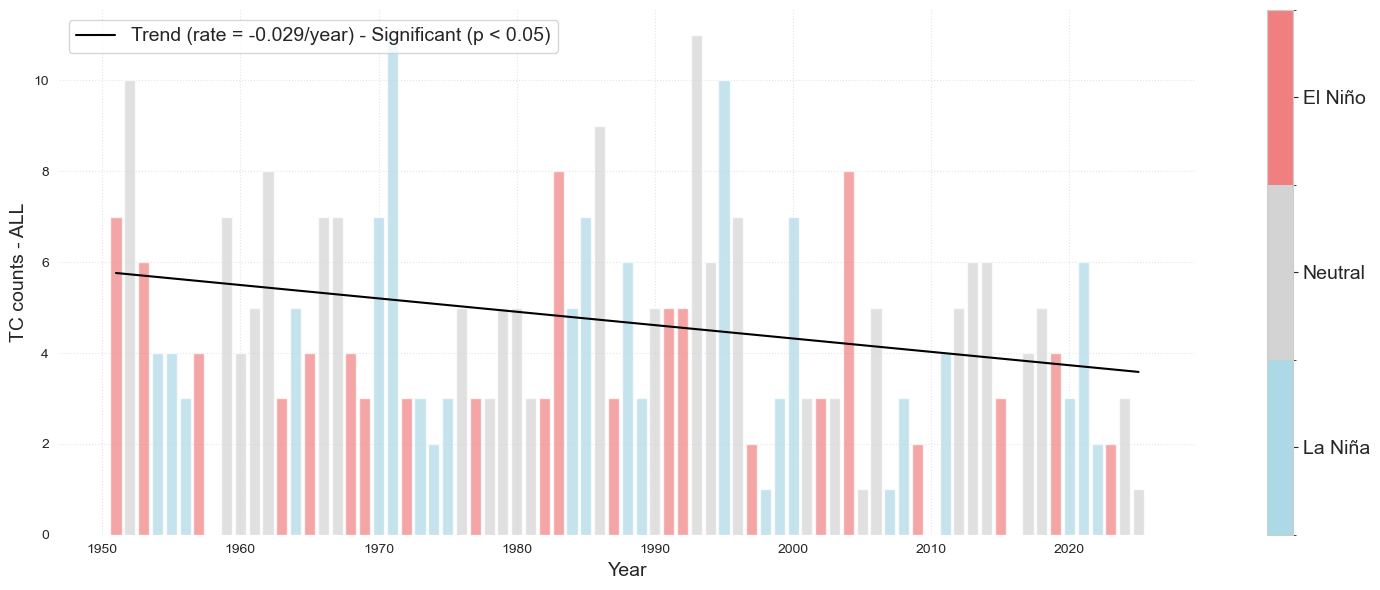

In [32]:
ax = plot_bar_probs_ONI(oni_y, 'tc_counts', y_label= 'TC counts - ALL');

The following bar plot represents the severe TC counts over time. The color of the bar represents wether it is a El Niño or La Niña year.

## ALL TCs

The following plots represent all the TCs in the record for the three different phases of the El Niño Southern Oscillation: "El Niño", "Neutral" and "La Niña"

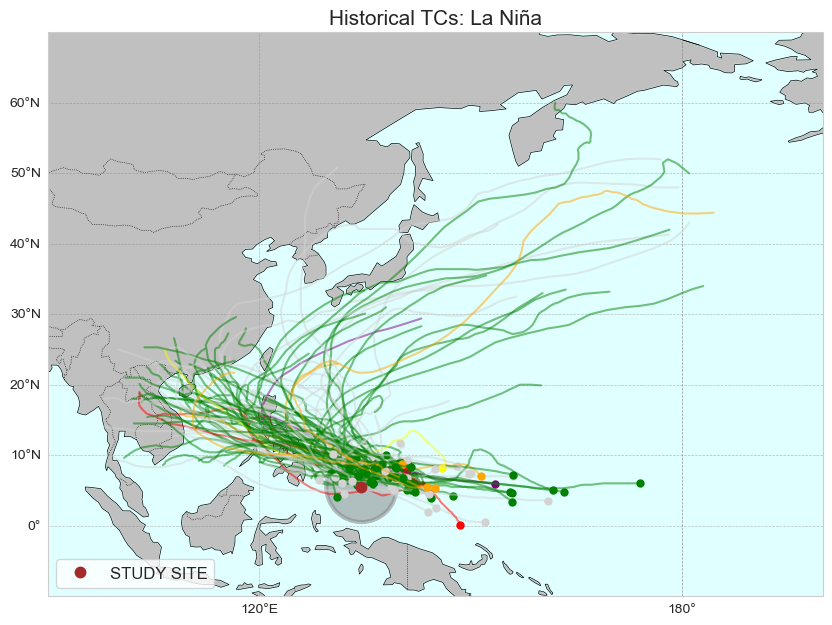

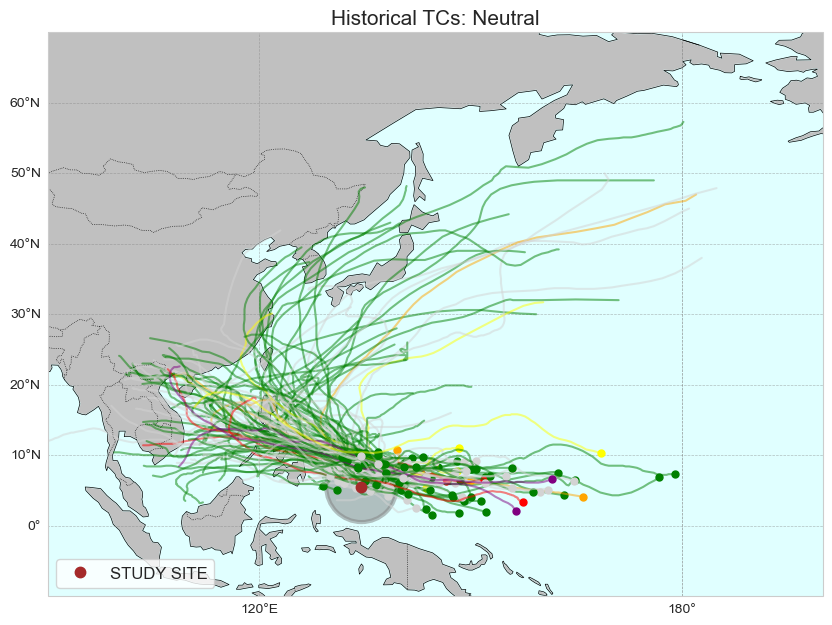

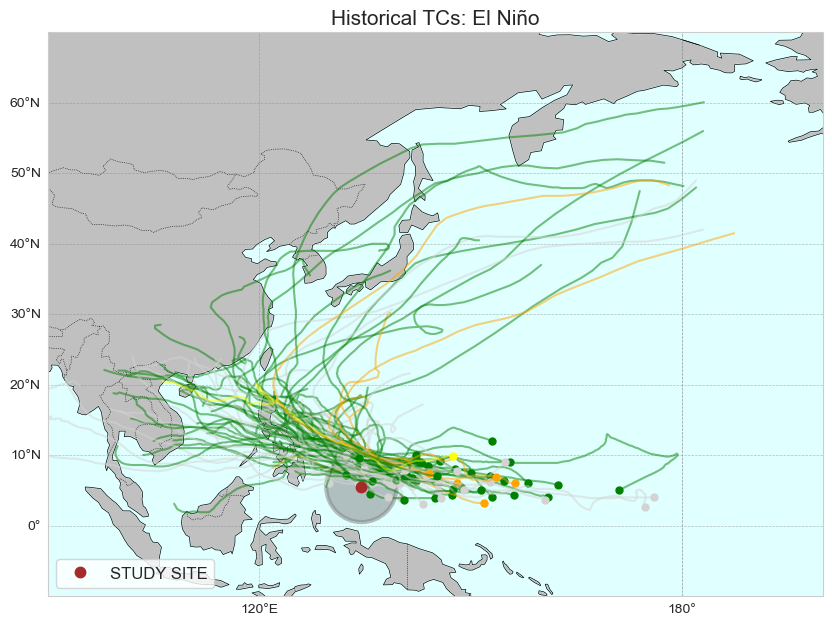

In [33]:
names_cat = ['La Niña', 'Neutral', 'El Niño']

for ic, category in enumerate([-1, 0, 1]):

    tcs_cat = tcs_sel.where(tcs_sel_params.oni_cat == category, drop = True)
    tcs_cat_params = tcs_sel_params.where(tcs_sel_params.oni_cat == category, drop = True)

    fig, ax = Plot_TCs_HistoricalTracks_Category(
        tcs_cat, tcs_cat_params.category,
        lon1, lon2, lat1, lat2,
        lon_lat[0], lon_lat[1], r1,
    )
    ax.set_title(f'Historical TCs: {names_cat[ic]}', fontsize=15)

    plt.savefig(op.join(path_figs, f'F9_TCs_{names_cat[ic]}.png'), dpi=300, bbox_inches='tight')


## Generate table
Table sumarizing different metrics of the data analyzed in the plots above

In [34]:
from ind_setup.tables import style_matrix, table_tcs_32a, table_tcs_32b

In [35]:
style_matrix(table_tcs_32a(tcs_sel_params, oni), title = 'Key TC Metrics: Vicinity of Palau')

Metric,Value
Total number of tracks,339.000
Tropical Storms per year,2.411
Standard deviation of storms per year,1.673
Maximum number of storms in a year 1971,9.000
Minimum number of storms in a year 1956,1.000
Major Hurricanes (Category 3+) per year,0.123
Standard deviation of major hurricanes per year,0.331
Maximum number of major hurricanes in a year 1964,2.000
Minimum number of major hurricanes in a year 1959,1.000
,


In [36]:
style_matrix(table_tcs_32b(tcs_WP, oni), title = 'Key TC Metrics: West Pacific Basin')

Metric,Value
Total number of tracks,2664.000
Tropical Storms per year,20.403
Standard deviation of storms per year,7.797
Maximum number of storms in a year 1950,47.000
Minimum number of storms in a year 1982,9.000
Major Hurricanes (Category 3+) per year,6.039
Standard deviation of major hurricanes per year,2.597
Maximum number of major hurricanes in a year 2015,14.000
Minimum number of major hurricanes in a year 1998,1.000
,
